In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
layer_size_list = [2,10,1]
np.random.seed(50)
weight_list = [np.random.normal(0,0.1,(layer_size_list[x]+1,layer_size_list[x+1])) for x in range(len(layer_size_list)-1)]
no_of_layers = 3
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW6\Dataset'
train_data_all = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data_all = pd.read_csv(path+'\DigitsTesting.csv',header=None)
train_data = train_data_all.sample(n=500)
test_data = test_data_all.sample(n=500)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)
train_labels = train_data[0]
#train_data = train_data.drop([0],axis=1)

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def identity(z):
    return z
def feedforward(datapoint,weight_list):
    prev_layer_activations = datapoint
    signal_list = [0]*(no_of_layers-1)
    activations_list = [0]*no_of_layers
    activations_list[0] = datapoint
    for layer in range(1,no_of_layers):     # l= 2 to L
        WX = np.dot(weight_list[layer-1].T,prev_layer_activations)   
        Z = WX
        signal_list[layer-1] = Z
        if layer == 2:
            activation_Z = identity(Z)
        else:
            activation_Z = tanh(Z)
        x_n = np.empty((activation_Z.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = activation_Z
        activations_list[layer] = x_n
        prev_layer_activations = x_n
    return signal_list,activations_list

In [4]:
def backprop(x,y):
    x_n = np.empty((x.shape[0]+1,))
    x_n[0] = 1
    x_n[1:] = x
    s_l,x_l = feedforward(x_n,weight_list)
    delta_L_tanh = 2 * (x_l[-1][1:] - y) * (1 - x_l[-1][1:]*x_l[-1][1:])
    delta_L_identity = 2 * (x_l[-1][1:] - y)
    deltas_list = [0]*(no_of_layers-1)
    deltas_list[-1] = delta_L_identity
    upstream_gradient = delta_L_identity
    for l in range(no_of_layers-2,0,-1):
        theta_dash_s_l = 1 - x_l[l][1:]*x_l[l][1:]
        delta_l = theta_dash_s_l * np.dot(weight_list[l][1:],upstream_gradient)
        upstream_gradient = delta_l
        deltas_list[l-1] = delta_l
    return deltas_list,x_l

In [5]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][1] = symmetry
        if int(image_pixels[0]) == 1:                   # Suppose digit 1 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose all other digits have label = +1
    return dataset,true_labels
d_2_train_dataset,d_2_train_labels = Extract_features(train_data)
d_2_test_dataset,d_2_test_labels = Extract_features(test_data)
d_2_train_dataset_all,d_2_train_labels_all = Extract_features(train_data_all)
d_2_test_dataset_all,d_2_test_labels_all = Extract_features(test_data_all)

In [6]:
d_2_train_dataset.shape

(500, 2)

In [7]:
def GD(weight_list,d_2_train_dataset,d_2_train_labels,learning_rate):
    w = weight_list
    D = d_2_train_dataset
    N = len(D)
    y = d_2_train_labels
    E_in = 0
    g = [0] * (no_of_layers-1)
    for index,d in enumerate(D):
        deltas_list,x_l = backprop(d,y[index])
        E_in += (1/N) * (x_l[-1][1] - y[index])**2
        for l in range(1,no_of_layers):
            delta = deltas_list[l-1].reshape((deltas_list[l-1].shape[0],1))
            x_l_previos = x_l[l-1].reshape((x_l[l-1].shape[0],1)) 
            G_l_xn = np.dot(x_l_previos,delta.T)
            g[l-1] += (1/N) * G_l_xn
    for l in range(1,no_of_layers):
        weight_list[l-1] -= learning_rate * g[l-1]
    return E_in,weight_list

# Time

In [8]:
def train_GD(epochs,test_data,test_labels):
    E_in_list = [0] * epochs
    E_out_list = [0] * epochs
    for epoch in range(epochs):
        E_out = 0
        E_in_list[epoch],weight_list_new = GD(weight_list,d_2_train_dataset,d_2_train_labels,0.01)
        for key,value in enumerate(test_data):
            x_n = np.empty((value.shape[0]+1,))
            x_n[0] = 1
            x_n[1:] = value
            s_l,x_l = feedforward(x_n,weight_list_new)
            E_out += (1/len(test_data))*(test_labels[key] - x_l[-1][1])**2
        E_out_list[epoch] = E_out
    return E_in_list,E_out_list,weight_list_new
start_time = time.time()
errors_GD_train,errors_GD_test,weight_list_new_GD = train_GD(10000,d_2_test_dataset,d_2_test_labels)
print('Time taken for Gradient Descent :',(time.time() - start_time))

Time taken for Gradient Descent : 268.9894824028015


Text(0.5,1,'Error vs Epochs for Train and Test')

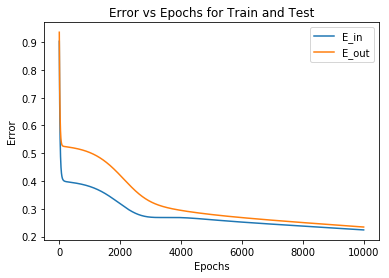

In [9]:
plt.plot(errors_GD_test)
plt.plot(errors_GD_train)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(['E_in','E_out'])
plt.title('Error vs Epochs for Train and Test')

# Plots

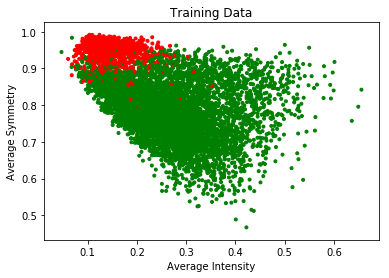

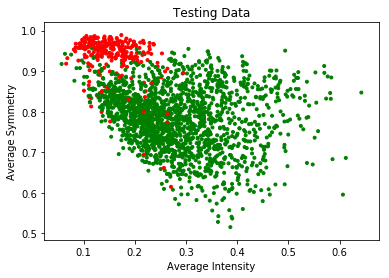

In [10]:
def Set_Colors_Array(true_labels):
    col = [None]*len(true_labels)
    for i in range(len(true_labels)):
        if int(true_labels[i]) == -1:
            col[i] = 'r'
        else:
            col[i] = 'g'
    return col
colors_train = Set_Colors_Array(d_2_train_labels_all)
colors_test = Set_Colors_Array(d_2_test_labels_all)
def Scatter_Plot(dataset,colors,title):           # Red = digit 2 and Green = digit 1
    x = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(x,y,c= colors,marker='.')
    plt.xlabel('Average Intensity')
    plt.ylabel('Average Symmetry')
    plt.title(title)
    plt.show()
Scatter_Plot(d_2_train_dataset_all,colors_train,'Training Data')
Scatter_Plot(d_2_test_dataset_all,colors_test,'Testing Data')

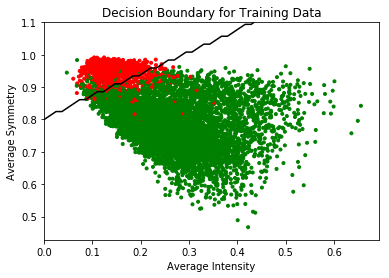

In [11]:
def Plot_Results(dataset,colors,W,title):
    x = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(x,y,c= colors,marker='.')
    plt.xlabel('Average Intensity')
    plt.ylabel('Average Symmetry')
    plt.title(title)
    x_values = np.linspace(0,0.6)
    y_values = np.linspace(0.5,1.1)
    """https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy"""
    # Meshgrid creates rectangular grid with x axis steps defined by x array and y axis grid steps defined by y array
    x_grid,y_grid = np.meshgrid(x_values,y_values)
    data = np.c_[x_grid.ravel(),y_grid.ravel()]
    s_l = [0]* len(data)
    x_l = [0]* len(data)
    pred = [0]* len(data)
    for key,value in enumerate(data):
        x_n = np.empty((value.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = value
        s_l[key],x_l[key] = feedforward(x_n,W)
        if np.float32(x_l[key][-1][1:]) > 0:
            pred[key] = 1
        else:
            pred[key] = -1
    Z = np.array(pred).reshape(x_grid.shape)
    plt.contour(x_values,y_values,Z,[0],colors='k',linestyles='solid')
Plot_Results(d_2_train_dataset_all,colors_train,weight_list_new_GD,'Decision Boundary for Training Data')

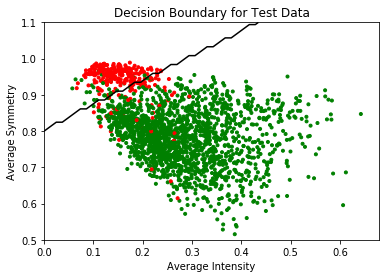

In [12]:
Plot_Results(d_2_test_dataset_all,colors_test,weight_list_new_GD,'Decision Boundary for Test Data')

In [13]:
def evaluate(test_data,test_labels,weight_list_new):
    cnt = 0
    for index,x in enumerate(test_data):
        x_n = np.empty((x.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = x
        x_l = feedforward(x_n,weight_list)[1]
        if x_l[-1][1] > 0 and test_labels[index] == 1:
            cnt += 1
        if x_l[-1][1] < 0 and test_labels[index] == -1:
            cnt += 1
    return cnt
cnt = evaluate(d_2_test_dataset,d_2_test_labels,weight_list_new_GD)

# Accuracy

In [14]:
print('Error on test data :',(1-cnt/len(d_2_test_dataset))*100)
print('Error Accuracy on train data :',errors_GD_train[-1])

Error on test data : 3.0000000000000027
Error Accuracy on train data : 0.23424529126856897


Text(0.5,1,'log10(Error) vs log10(Epochs) for Train and Test')

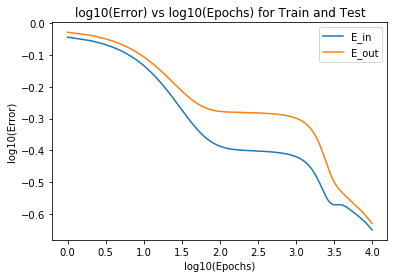

In [15]:
E_in_list = np.log10(errors_GD_train)
E_out_list = np.log10(errors_GD_test)
iters = np.log10([i for i in range(1,10001)])
plt.plot(iters,E_out_list)
plt.plot(iters,E_in_list)
plt.xlabel('log10(Epochs)')
plt.ylabel('log10(Error)')
plt.legend(['E_in','E_out'])
plt.title('log10(Error) vs log10(Epochs) for Train and Test')

# Comparisions

Results are as expected. Gradient decent decreases in sample error and finds a global optima. Hence E in(0.234) is less than E out(3.00). Gradient descent finds exact gradient and each step and hence takes a long time to converge which can be seen from the plot. Even after 10000 epochs, the graph is not a constant line parallel to x axis.
Also since E_in is < E_out so its not overfitting.